# SET UP

### IMPORT LIBRARIES

In [5]:
import argparse
import ast
import csv
import itertools
import json
import os
import re

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.linalg as la
from netgraph import InteractiveGraph, Graph
from numpy.linalg import eig
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm

import quantecon as qe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### DEFINE GLOBAL VARIABLE

In [6]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())
DICT_amper2int = {item: index for index, item in enumerate(allampers)}

with open('data_gen/allprovincesTH.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        allprovinces.append(line.strip())
DICT_province2int = {item: index for index, item in enumerate(allprovinces)}

KeyboardInterrupt: 

In [155]:
ampers_lists_df = pd.read_csv("data_gen/ampers_lists.csv")
DICT_amperTH2EN = dict()
for amper in allampers:
    df = ampers_lists_df[(ampers_lists_df["Amper TH"] == amper[0]) & (ampers_lists_df["Province TH"] == amper[1])]
    DICT_amperTH2EN[amper] = (df.iloc[0]["Amper EN"], df.iloc[0]["Province EN"])

In [142]:
district_lists_df = pd.DataFrame(columns=['District Tuple', 'Lat', 'Lon'])

for i in range(len(ampers_lists_df)):
    newrow_dict = dict()
    newrow_dict['District Tuple'] = (ampers_lists_df.iloc[i]["Amper EN"], ampers_lists_df.iloc[i]["Province EN"])
    newrow_dict['Lat'] = ampers_lists_df.iloc[i]["Lat"]
    newrow_dict['Lon'] = ampers_lists_df.iloc[i]["Lon"]
    newrow_df = pd.DataFrame([newrow_dict]) 

    district_lists_df = pd.concat([district_lists_df, newrow_df], ignore_index=True)

district_lists_df.to_csv("data_final/districts_list.csv")

/var/folders/b2/dxx_j33x7rz80jfgfjr_tj2c0000gn/T/ipykernel_47934/2179313058.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  district_lists_df = pd.concat([district_lists_df, newrow_df], ignore_index=True)


In [157]:
############################################################
district_distanceTH_df = pd.read_csv("data_final/district_distance.csv")
district_distanceTH_df.head()

,Unnamed: 0,original_tuple,destination_tuple,distance
0,0,"('แม่สะเรียง', 'แม่ฮ่องสอน')","('ฮอด', 'เชียงใหม่')",177 km
1,1,"('แม่สะเรียง', 'แม่ฮ่องสอน')","('อมก๋อย', 'เชียงใหม่')",116 km
2,2,"('แม่สะเรียง', 'แม่ฮ่องสอน')","('แม่ลาน้อย', 'แม่ฮ่องสอน')",32.2 km
3,3,"('แม่สะเรียง', 'แม่ฮ่องสอน')","('สบเมย', 'แม่ฮ่องสอน')",26.2 km
4,4,"('แม่สะเรียง', 'แม่ฮ่องสอน')","('แม่แจ่ม', 'เชียงใหม่')",128 km


In [160]:
district_distanceTH_df.iloc[i]["original_tuple"]

"('แม่สะเรียง', 'แม่ฮ่องสอน')"

In [162]:
############################################################
district_distanceTH_df = pd.read_csv("data_final/district_distance.csv")
district_adjacency_pair_df = pd.DataFrame(columns=['Origin', 'Destination', 'Distance'])
for i in range(len(district_distanceTH_df)):
    newrow_dict = dict()
    newrow_dict['Origin'] = DICT_amperTH2EN[ast.literal_eval(district_distanceTH_df.iloc[i]["original_tuple"])]
    newrow_dict['Destination'] =  DICT_amperTH2EN[ast.literal_eval(district_distanceTH_df.iloc[i]["destination_tuple"])]
    
    newrow_dict["Distance"] =  district_distanceTH_df.iloc[i]["distance"]
    new_row_df = pd.DataFrame([newrow_dict]) 
    district_adjacency_pair_df = pd.concat([district_adjacency_pair_df, new_row_df], ignore_index=True)

district_adjacency_pair_df.to_csv("data_final/district_adjacency_pair.csv")

In [140]:
ampers_lists_df = pd.read_csv("data_gen/ampers_lists.csv")
 

ampers_lists_TH_from_csv = list(ampers_lists_df["Amper TH"])
province_lists_TH_from_csv = set(ampers_lists_df["Province TH"])

ampers_lists_from_allampers = []
for amper in allampers:
    ampers_lists_from_allampers.append(amper[0])

for amper in ampers_lists_from_allampers:
    if amper not in ampers_lists_TH_from_csv:
        print(amper)
    
for amper in ampers_lists_TH_from_csv:
    if amper not in ampers_lists_from_allampers:
        print(amper)

for province in allprovinces:
    if province not in province_lists_TH_from_csv:
        print(province)

In [106]:
import pandas as pd
import json

############################################################
with open("data_gen/provincesTH2EN.json", 'r', encoding='utf-8') as file:
    DICT_provinceTH2EN = json.load(file)

############################################################
provinces_lat_lon_df = pd.read_csv("data_gen/provinces_lat_lon.csv")
provinces_list_df = pd.DataFrame(columns=['Name', 'Lat', 'Lon'])

for province in allprovinces:
    province_dict = dict()
    province_dict['Name'] = DICT_provinceTH2EN[province]
    province_dict['Lat'] = provinces_lat_lon_df[provinces_lat_lon_df["จังหวัด"] == province].iloc[0]["Lat"]
    province_dict['Lon'] = provinces_lat_lon_df[provinces_lat_lon_df["จังหวัด"] == province].iloc[0]["Lon"]
    new_row_df = pd.DataFrame([province_dict]) 
    provinces_list_df = pd.concat([provinces_list_df, new_row_df], ignore_index=True)

provinces_list_df.to_csv("data_final/provinces_list.csv")

############################################################
provinces_distance = pd.read_csv("data_final/provinces_distance.csv")
provinces_adjacency_pair_df = pd.DataFrame(columns=['Origin', 'Destination', 'Distance'])
for i in range(len(provinces_distance)):

    newrow_dict = dict()
    newrow_dict['Origin'] = DICT_provinceTH2EN[provinces_distance.iloc[i]["original"]]
    newrow_dict['Destination'] =    DICT_provinceTH2EN[provinces_distance.iloc[i]["destination"]]
    newrow_dict["Distance"] =  provinces_distance.iloc[i]["distance"]
    new_row_df = pd.DataFrame([newrow_dict]) 
    provinces_adjacency_pair_df = pd.concat([provinces_adjacency_pair_df, new_row_df], ignore_index=True)

provinces_adjacency_pair_df.to_csv("data_final/provinces_adjacency_pair.csv")


/var/folders/b2/dxx_j33x7rz80jfgfjr_tj2c0000gn/T/ipykernel_47934/1466595185.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  provinces_list_df = pd.concat([provinces_list_df, new_row_df], ignore_index=True)


# PROVINCES

In [10]:
csvfiles_path = "data_gen_distance_provinces/"  
csvfiles = os.listdir(csvfiles_path)

import pandas as pd
 
df_list= []
total = 0

for csvfile in csvfiles:
    if csvfile.split(".")[-1] == 'csv':
        csvfile_path = csvfiles_path+ csvfile
        df = pd.read_csv(csvfile_path)
        df_list.append(df)
        N = len(df)
        total  +=N

result = pd.concat(df_list, ignore_index=True)
result = result[["original", "destination", "distance"]]
result.to_csv("data_final/provinces_distance.csv", encoding='utf-8-sig')

## GEN PROVINC ADJACENCTY AND DISTANCE MATRIX

In [ ]:
import pandas as pd
import numpy as np

provinces_lat_lon_df = pd.read_csv("data_gen/provinces_lat_lon.csv")

A = np.zeros([len(provinces_lat_lon_df),len(provinces_lat_lon_df)])
D = np.zeros([len(provinces_lat_lon_df),len(provinces_lat_lon_df)])

original_destination_df = pd.read_csv("data_gen_distance_provinces/provinces_distanceTH.csv")
for i in range(len(original_destination_df)):
    original_province_name = original_destination_df.iloc[i]["original"]
    destination_province_name = original_destination_df.iloc[i]["destination"]
    distance = original_destination_df.iloc[i]["distance"].replace("km", "").replace(" ", "")

    original_index = DICT_province2int[original_province_name]
    destination_index = DICT_province2int[destination_province_name]
    A[original_index, destination_index] = 1
    D[original_index, destination_index] = distance

A = (A+A.T)/2
D = (D+D.T)/2

# A_df = pd.DataFrame(A, index=allprovinces, columns=allprovinces)
# D_df = pd.DataFrame(D, index=allprovinces, columns=allprovinces)


A_df = pd.DataFrame(A, index=allprovinces_EN, columns=allprovinces_EN)
D_df = pd.DataFrame(D, index=allprovinces_EN, columns=allprovinces_EN)
A_df.to_csv("data_final/province_A.csv", encoding='utf-8-sig')
D_df.to_csv("data_final/province_D.csv", encoding='utf-8-sig')



## PROVINCE VISUALIZATION

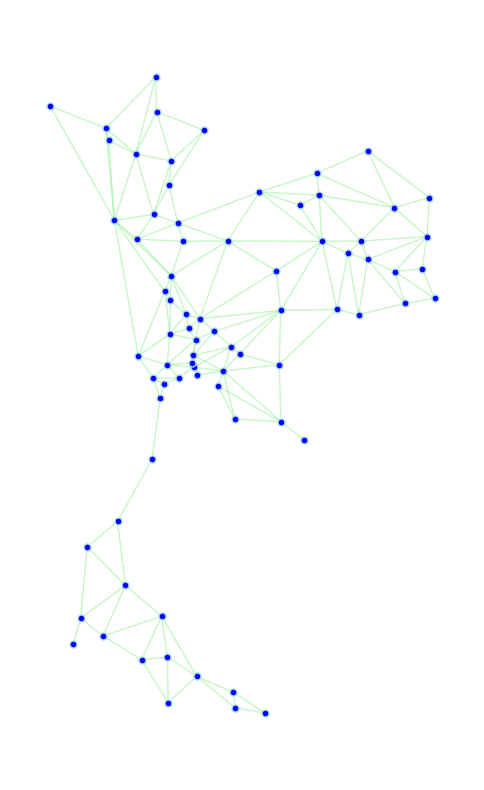

In [6]:
provinces_lat_lon_df = pd.read_csv("data_gen/provinces_lat_lon.csv")
positions = dict()
for i in range(len(provinces_lat_lon_df)):
    #จังหวัด,Lat,Lon
    provincename = provinces_lat_lon_df.iloc[i]["จังหวัด"]
    Lat = provinces_lat_lon_df.iloc[i]["Lat"]
    Lon = provinces_lat_lon_df.iloc[i]["Lon"]

    province_index = DICT_province2int[provincename]
    positions[province_index] = (Lon, Lat)

G = nx.from_numpy_array(A)


nx.draw_networkx_edges(G, positions, alpha=0.5, edge_color='lightgreen', width =1)
nx.draw_networkx_nodes(G, positions, node_color='blue', node_size=25, edgecolors='lightblue', linewidths=1)

# nx.draw_networkx_labels(G, positions, labels=labels, font_size=8, font_family='sans-serif')
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='blue', node_size=800, font_size=15)

plt.axis('off')  # Removes the axis for a cleaner look
plt.gcf().set_size_inches(6, 10)  # Adjust the figure size if necessary for better visibility
 
plt.show()

In [4]:
D

NameError: name 'D' is not defined

NameError: name 'DICT_province2int' is not defined

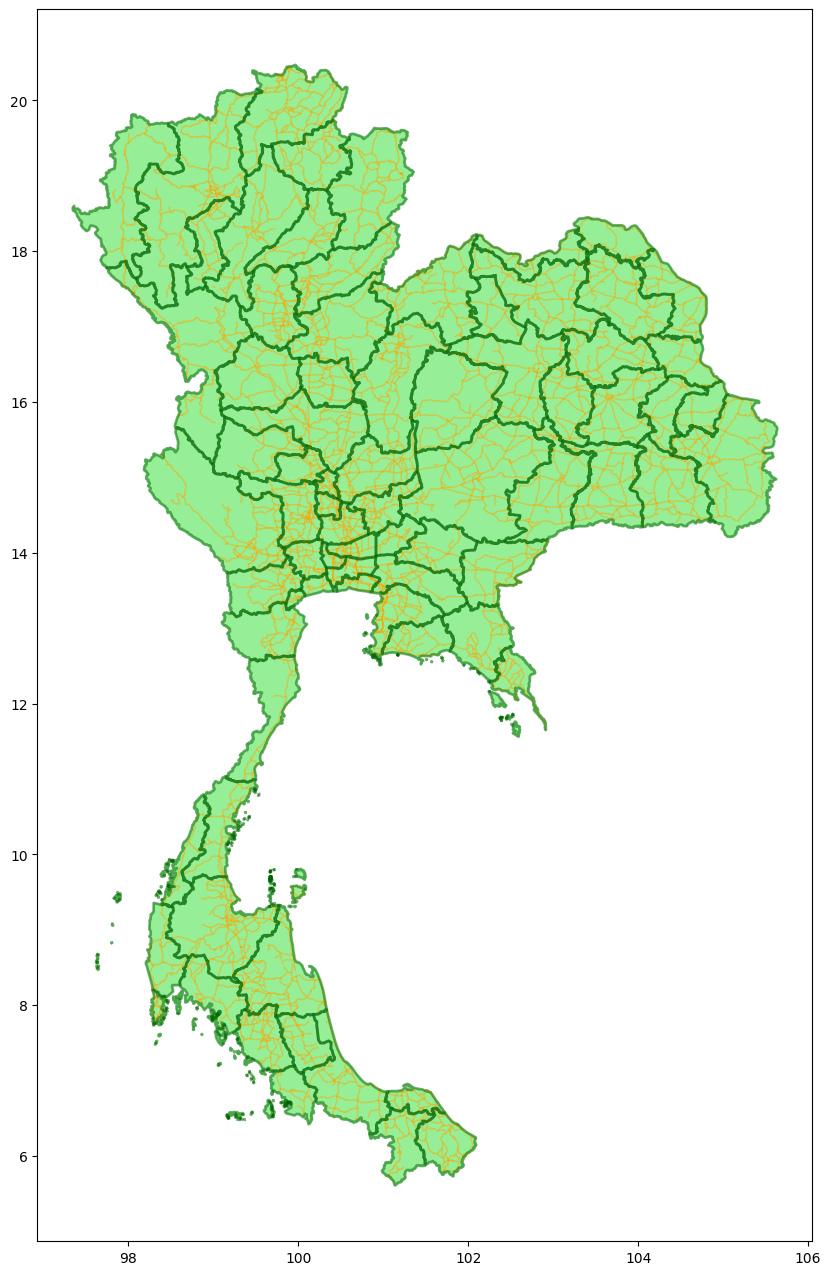

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### MAIN PLOT ###
fig, ax = plt.subplots(figsize=(10, 16))


### ROAD ###
DATA_FOLDER = "data_base/road/"
file_paths_list = [
    "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
    "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
    "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
    "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
    "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
    "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
]

road_color = 'orange'
road_width = 1
road_alpha = 0.5

for file_path in file_paths_list:
    roads = gpd.read_file(DATA_FOLDER + file_path)
    for x, y in roads.geometry.apply(lambda geom: zip(*geom.coords)):
        ax.plot(x, y, color=road_color, alpha=road_alpha, linewidth=road_width)

provinces = gpd.read_file('data_base/boundary/query.geojson')

# cmap = plt.cm.get_cmap('winter', len(provinces))  # Choose any available colormap
fillcolor = "lightgreen"
for i in range(len(provinces['pv_tn'])):
    geom = provinces["geometry"][i]
    pv_name = provinces['pv_tn'][i]

    # fillcolor = mcolors.to_hex(cmap(i))
    plot_settings = {'color': fillcolor, 'alpha': 0.95}

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='darkgreen', alpha=0.5,  linewidth=2)
        ax.fill(x, y, **plot_settings)


    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms: 
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='darkgreen', alpha=0.5, linewidth=2)    
            ax.fill(x, y, **plot_settings)
    

# PLOT EDGES
csvfile_path = "data_gen_adjacency_provinces/adjacency_provinces.csv"  
df = pd.read_csv(csvfile_path)
N = len(df)
for i in range(N):

    province1 =  df.iloc[i]["province1"]
    province2  = df.iloc[i]["province2"]

    province1_index = DICT_province2int[province1]
    province2_index = DICT_province2int[province2]
    province1_position = positions[province1_index]
    province2_position = positions[province2_index]
    
    x_values = [province1_position[0], province2_position[0]]
    y_values = [province1_position[1], province2_position[1]]

    ax.plot(x_values, y_values, marker='o', linestyle='-')

## PLOT NODES
# for i in range(len(provinces['pv_tn'])):
#     centerx, centery = positions[DICT_province2int[pv_name]]
#     ax.plot(centerx, centery, 'o', color='blue', alpha=0.5, markersize=10)

plt.show()

## PROVINCE USE CASE: COMMUNITY DETECTION

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

G = nx.from_numpy_array(A)
# Load karate graph and find communities using Girvan-Newman
# G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "lightblue"][:number_of_colors]
    node_colors = []
    node_labels =[]
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                node_labels.append(current_community_index+1)
                break
            current_community_index += 1
    return node_colors, node_labels

def visualize_communities(graph, communities):
    node_colors, node_labels = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    # pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    # plt.subplot(3, 1, i)
    plt.title(title)

    # custom_labels = {node: "Label" + str(node) for node in graph.nodes()}

    nx.draw(
        graph,
        pos=positions,
        node_size=200,
        node_color=node_colors,
        with_labels=True,
        labels=node_labels,  # Use this to specify custom labels
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(figsize=(10, 16))

for i in range(len(provinces['pv_tn'])):
    geom = provinces["geometry"][i]
    pv_name = provinces['pv_tn'][i]

    # fillcolor = mcolors.to_hex(cmap(i))
    plot_settings = {'color': fillcolor, 'alpha': 0.1}

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='darkgreen', alpha=0.95,  linewidth=2)
        ax.fill(x, y, **plot_settings)


    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms: 
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='darkgreen', alpha=0.95, linewidth=2)    
            # plot_settings = {'color': fillcolor, 'alpha': 0.1}
            ax.fill(x, y, **plot_settings)

visualize_communities(G, communities[3]) 

plt.show()

/var/folders/b2/dxx_j33x7rz80jfgfjr_tj2c0000gn/T/ipykernel_54606/2464025856.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


NameError: name 'D' is not defined

# DISTRICTS

### VISUALIZATION 

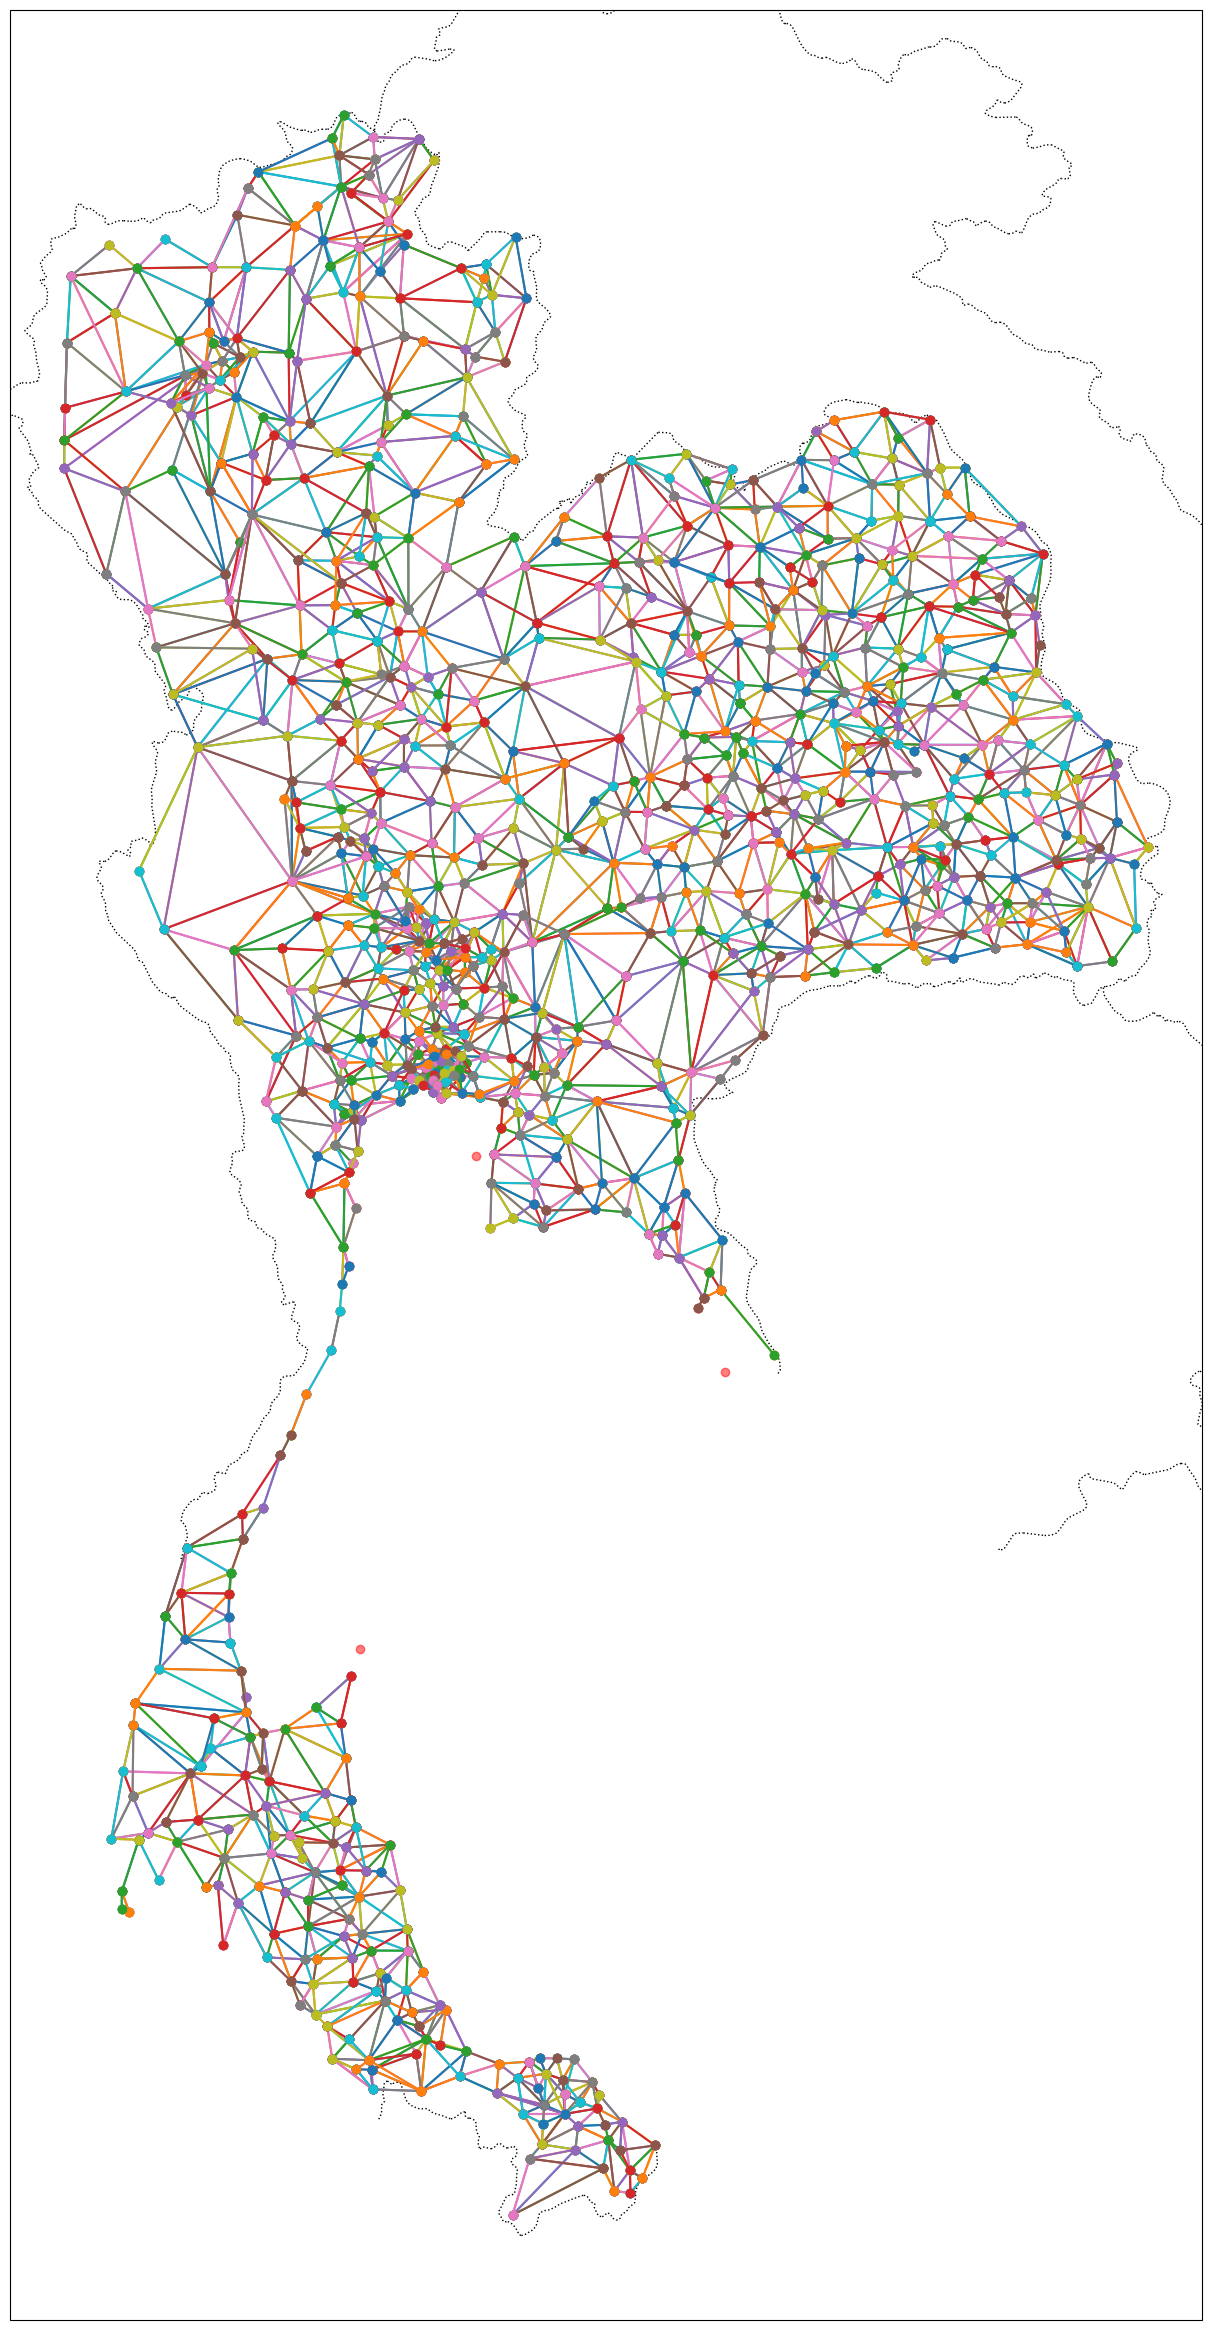

In [90]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd

allampers_collected_df = pd.read_csv("data_gen/allampers_collected.csv")

ampers_positions = dict()

for i in range(len(allampers_collected_df)):
    amper_name = allampers_collected_df.iloc[i]["Amper TH"]
    province_name =  allampers_collected_df.iloc[i]["Province TH"]
    lat = allampers_collected_df.iloc[i]["Lat"]
    lon = allampers_collected_df.iloc[i]["Lon"]
    amper_tuple = (amper_name, province_name)
    ampers_positions[DICT_amper2int[amper_tuple]] = (lon,lat)

# # Define map appearance
plt.figure(figsize=(20, 30))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1) 

# Define colors and widths for clarity and consistency
region_edge_color = 'green'
river_color = 'blue'
road_color = 'grey'
road_width = 3
road_alpha = 0.5

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

regions = [central, east, north, south, northeast, west]

# cmap = plt.cm.get_cmap('winter', len(allampers))
# for region in regions:
#       # Choose any available colormap
#     for i in range(len(region['ap_tn'])):
#         geom = region["geometry"][i]
#         ap_tn = region['ap_tn'][i]
#         pv_tn = region['pv_tn'][i]

#         amper_tuple = (ap_tn, pv_tn)

#         # color = mcolors.to_hex(cmap(i))
#         plot_settings = {'color': "lightgreen", 'alpha': 0.1}
        
#         if geom.geom_type == 'Polygon':
#             x, y = geom.exterior.xy
#             ax.plot(x, y, color='darkgreen', alpha=0.5,  linewidth=2)
#             ax.fill(x, y, **plot_settings)

#         elif geom.geom_type == 'MultiPolygon':
#             for polygon in geom.geoms: 
#                 x, y = polygon.exterior.xy
#                 ax.plot(x, y, color='darkgreen', alpha=0.5, linewidth=2)    
#                 ax.fill(x, y, **plot_settings)
        
#         centerx, centery = ampers_positions[DICT_amper2int[amper_tuple]]
#         ax.plot(centerx, centery, 'o', color='blue', alpha=0.5, markersize=10)

# for region in regions:
#     ax.add_geometries(region['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=region_edge_color)

for lat, lon in zip(allampers_collected_df['Lat'], allampers_collected_df['Lon']):
    ax.plot(lon, lat, 'o', color='red', alpha=0.5)

csvfiles_path = "data_gen_adjacency_districts/"  
csvfiles = os.listdir(csvfiles_path)
for csvfile in csvfiles:
    csvfile_path = csvfiles_path+ csvfile
    df = pd.read_csv(csvfile_path)
    N = len(df)
    for i in range(N):

        amper1_tuple = ast.literal_eval(df.iloc[i]["Amper1"])
        amper2_tuple  = ast.literal_eval(df.iloc[i]["Amper2"])
        amper1_index = DICT_amper2int[amper1_tuple]
        amper2_index = DICT_amper2int[amper2_tuple]

        amper1_position = ampers_positions[amper1_index]
        amper2_position = ampers_positions[amper2_index]
        
        x_values = [amper1_position[0], amper2_position[0]]
        y_values = [amper1_position[1], amper2_position[1]]

        ax.plot(x_values, y_values, marker='o', linestyle='-')
        plot_settings = {'color': fillcolor, 'alpha': 0.1}

# # Add river geometries
# rivers = gpd.read_file("data_base/road/2022-08-17-filter.geojson").to_crs(epsg=4326)
# ax.add_geometries(rivers['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=river_color)

# Define road file paths
# DATA_FOLDER = "data_base/road/"
# file_paths_list = [
#      "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
#      "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
#      "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
#  ]

# # # Add road data
# for file_path in file_paths_list:
#     roads = gpd.read_file(DATA_FOLDER + file_path)
#     for x, y in roads.geometry.apply(lambda geom: zip(*geom.coords)):
#         ax.plot(x, y, color=road_color, alpha=road_alpha, linewidth=road_width)

plt.show()

### ADJACENCY MATRIX

In [90]:
## GEN DISTRICTS DISTANCE

csvfiles_path = "data_gen_distance_districts/"  
csvfiles = os.listdir(csvfiles_path)

import pandas as pd
 
df_list= []
total = 0

for csvfile in csvfiles:
    if csvfile.split(".")[-1] == 'csv':
        csvfile_path = csvfiles_path+ csvfile
        df = pd.read_csv(csvfile_path)
        df_list.append(df)
        N = len(df)
        total  +=N

result = pd.concat(df_list, ignore_index=True)
result = result[["original_tuple", "destination_tuple", "distance"]]
result.to_csv("data_final/district_distance.csv", encoding='utf-8-sig')

### Adjacency and Distance Matrix

In [156]:
district_distance_df = pd.read_csv("data_final/district_distance.csv")
N_districts = len(allampers) 
A = np.zeros([N_districts, N_districts])
D = np.zeros([N_districts, N_districts])
for i in range(len(district_distance_df)):
    original_tuple = ast.literal_eval(district_distance_df.iloc[i]['original_tuple'])
    original_index = DICT_amper2int[original_tuple]
    destination_tuple = ast.literal_eval(district_distance_df.iloc[i]['destination_tuple'])
    destination_index = DICT_amper2int[destination_tuple]

    distance = float(district_distance_df.iloc[i]['distance'].replace("km", "").replace(" ", ""))

    A[original_index, destination_index] = 1
    D[original_index, destination_index] = distance

A = (A+A.T)/2
D = (D+D.T)/2

# A_df = pd.DataFrame(A, index=allampers, columns=allampers)
# D_df = pd.DataFrame(D, index=allampers, columns=allampers)
allampers_EN = []
for amper in allampers:
    allampers_EN.append(DICT_amperTH2EN[amper])

A_df = pd.DataFrame(A, index=allampers_EN, columns=allampers_EN)
D_df = pd.DataFrame(D, index=allampers_EN, columns=allampers_EN) 
A_df.to_csv("data_final/district_A.csv", encoding='utf-8-sig')
D_df.to_csv("data_final/district_D.csv", encoding='utf-8-sig')




In [154]:
DICT_amperTH2EN

{('พระนคร', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('ดุสิต', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('บางรัก', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('พญาไท', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('บ้านนา', 'นครนายก'): ('Phra Nakhon', 'Bangkok'),
 ('องครักษ์', 'นครนายก'): ('Phra Nakhon', 'Bangkok'),
 ('หนองจอก', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('คลองเตย', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('บางเขน', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('พระโขนง', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('บางกะปิ', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('ปทุมวัน', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('ป้อมปราบศัตรูพ่าย', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('มีนบุรี', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('สัมพันธวงศ์', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('ลาดกระบัง', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),
 ('ยานนาวา', 'กรุงเทพมหานคร'): ('Phra Nakhon', 'Bangkok'),


## DISTRICT USE CASES

### DEGREE CENTRALITY

In [30]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 


df['district'] = [allampers[i] for i in range(len(allampers))]

centralities = nx.degree_centrality(G)

centrality_list = [value for value in centralities.values()]
df['degree'] = centrality_list

df.to_csv("usecases/province_centrality_degree.csv", encoding='utf-8-sig')

In [50]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 

df['district'] = [allampers[i] for i in range(len(allampers))]

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=10000)

centrality_list = [value for value in centralities.values()]
df['eigenvector'] = centrality_list

df.to_csv("usecases/province_centrality_eigenvector_adjacency.csv", encoding='utf-8-sig')

In [60]:
D

array([[ 0. ,  4.5,  8. , ...,  0. ,  0. ,  0. ],
       [ 3.6,  0. ,  7.1, ...,  0. ,  0. ,  0. ],
       [ 8.2,  7.8,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 16. ],
       [ 0. ,  0. ,  0. , ...,  0. , 16.2,  0. ]])

In [63]:
D_normalized =  np.zeros([D.shape[0], D.shape[0]])

# for i in range(D.shape[0]):
#     for j in range(D.shape[0]):
#         if D[i,j] > 500:
#             D[i,j] = 0

Dmax = D.max()
for i in range(D.shape[0]):
    for j in range(D.shape[0]):
        if D[i,j] != 0:
            D_normalized[i,j] = 1/D[i,j] 

D_normalized = (D_normalized+D_normalized.T)/2
D_normalized

array([[0.        , 0.25      , 0.12347561, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.        , 0.1345251 , ..., 0.        , 0.        ,
        0.        ],
       [0.12347561, 0.1345251 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0621142 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0621142 ,
        0.        ]])

In [64]:
G = nx.from_numpy_array(D_normalized) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=100000)

centrality_list = [value for value in centralities.values()]

df['eigenvector'] = centrality_list

df.to_csv("usecases/province_centrality_eigenvector_distance.csv", encoding='utf-8-sig')

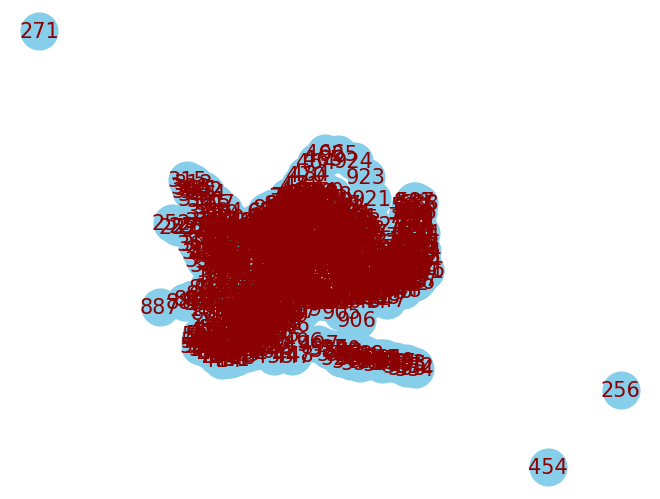

In [48]:
# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='#FF5733', font_size=15, font_color='darkred')

# Show the plot
plt.show()

In [77]:
df.keys()

Index(['Unnamed: 0', 'กรุงเทพมหานคร', 'สมุทรปราการ', 'นนทบุรี', 'ปทุมธานี',
       'พระนครศรีอยุธยา', 'อ่างทอง', 'ลพบุรี', 'สิงห์บุรี', 'ชัยนาท',
       'สระบุรี', 'ชลบุรี', 'ระยอง', 'จันทบุรี', 'ตราด', 'ฉะเชิงเทรา',
       'ปราจีนบุรี', 'นครนายก', 'สระแก้ว', 'นครราชสีมา', 'บุรีรัมย์',
       'สุรินทร์', 'ศรีสะเกษ', 'อุบลราชธานี', 'ยโสธร', 'ชัยภูมิ', 'อำนาจเจริญ',
       'บึงกาฬ', 'หนองบัวลำภู', 'ขอนแก่น', 'อุดรธานี', 'เลย', 'หนองคาย',
       'มหาสารคาม', 'ร้อยเอ็ด', 'กาฬสินธุ์', 'สกลนคร', 'นครพนม', 'มุกดาหาร',
       'เชียงใหม่', 'ลำพูน', 'ลำปาง', 'อุตรดิตถ์', 'แพร่', 'น่าน', 'พะเยา',
       'เชียงราย', 'แม่ฮ่องสอน', 'นครสวรรค์', 'อุทัยธานี', 'กำแพงเพชร', 'ตาก',
       'สุโขทัย', 'พิษณุโลก', 'พิจิตร', 'เพชรบูรณ์', 'ราชบุรี', 'กาญจนบุรี',
       'สุพรรณบุรี', 'นครปฐม', 'สมุทรสาคร', 'สมุทรสงคราม', 'เพชรบุรี',
       'ประจวบคีรีขันธ์', 'นครศรีธรรมราช', 'กระบี่', 'พังงา', 'ภูเก็ต',
       'สุราษฎร์ธานี', 'ระนอง', 'ชุมพร', 'สงขลา', 'สตูล', 'ตรัง', 'พัทลุง',
       'ปัตตานี', 'ยะลา', 'นราธิ

# GEN MATRICES

In [83]:
df = pd.read_csv("data_final/province_A.csv")
df = df.drop('Unnamed: 0', axis=1)
adjacency_matriix = df.values
adjacency_matriix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [86]:
df = pd.read_csv("data_final/province_D.csv")
df = df.drop('Unnamed: 0', axis=1)
distance_matriix = df.values
distance_matriix == distance_matriix.T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])